# What are you Studying?

## Abstract

JSTOR is a not-for-profit digital library created in 1995 to help university and college libraries free up space on their shelves, save costs, and provide greater levels of access to scholarly content. JSTOR has partnered with publishers of academic journals across more than 80 disciplines to provide online access to thousands of high-quality, peer-reviewed academic journals all the way back to the first issue published. 

Many of the 10,000 JSTOR participating institutions subscribe to multidisciplinary subsets of journals (known as collections). Consequently, it can be difficult to infer the academic strengths of an institution simply from the collections they license. I propose  that it is possible to determine academic program strengths at an institution by analyzing their usage of JSTOR content within specific disciplines.


Relatedly, I hypothesize that:
1. Having academic programs within a particular discipline will lead to higher usage of journal content within that discipline, relative to ‘similar’ institutions that do not have  programs  of study in that area (measured by comparing usage of a particular journal for institutions that have and do not have programs of study in that area);
2. Content usage in a particular discipline can be used to determine whether an institution has, or does not have, a field of study in that discipline;
3. Content usage can therefore be predicted for unlicensed content by examining the academic programs offered at that institution and comparing it to usage patterns for similar institutions.


## Overview of Data
For this analysis, I will use a combination of internally generated and externally collected data. 
### Usage data 
Usage data by journal for a selection of 22 of the 80 JSTOR disciplines. For every journal in the discipline, I have aggregated the usage at each subscribing institution for a 3-year period from 2013-2016. 

This data was retrieved from SQL tables of usage data and institution data. Each row of this dataset contains information about the institution (size, location, overall JSTOR usage) as well as the journal name, journal discipline, and usage for that specific journal. 
##### Size: 3 datasets (train, fit, test) that together total 6,765,337 rows

### Academic programs data
A dataset from the World Higher Education Database (WHED) containing information on academic programs offered at different universities worldwide. This dataset has an ID “key” to join this data to the JSTOR institution usage dataset. This dataset contains information for over 600 different programs of study (referred to in the data as "fields of study") offered at 17,000 colleges and universities worldwide.
###### Size: 456,860 rows

### Fields of Study to Disciplines Map

A dataset that “maps” the academic fields of study from the WHED dataset to the relevant JSTOR disciplines. This allows me to group these 660 fields of study into the 80 JSTOR disciplines to compare how many fields of study within each discipline a specific institution offers. 
###### Size: 850 rows


### Supplemental Datasets
Additional datasets were collected to supplement the 3 main datasets. These include:
#### Data by institution: usage of all JSTOR content over the same 3-year priod. 
This is to see what proportion of an institution's usage came from this specific journal.
#### Data by institution: usage of the collection containing the target journal. 
This is to see what proportion of an institution's usage of the collection that contains the journal came from this specific journal.
#### WHED Fields of Study Summary: number of fields of study listed for each instititution across all disciplines. 
This is to account for differences in reporting (some institutions may choose to only list 5 or 6 important areas of study, whereas others may list every single program offered).

## Reviewing and Aggregating Data

### Usage Data
##### Data: 
.csv files containing usage by institution for each journal of a discipline. The files were split by discipline into 3 folders: train, fit, and test.

##### Objective: 
For each folder, write all .csv files to a single dataset.

In [3]:
import pandas as pd
import numpy as np
import os
import shutil 
from matplotlib import pyplot as plt  
%matplotlib inline 
import seaborn as sb
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

In [8]:
#data_set can be changed to train, fit, test accordingly
data_set = 'Train'
Location = ''
path = Location + data_set + '/'
files = os.listdir(path)
#print files
for line in files:
    print line

african_american_studies.txt
art_and_art_history.txt
art_and_art_history_2.txt
economics_1.txt
economics_2.txt
economics_3.txt
education_.txt
education_2.txt
education_3.txt
environmental_science.txt
language_and_literature_1.txt
language_and_literature_2.txt
language_and_literature_3.txt
language_and_literature_4.txt
language_and_literature_5.txt
political_science_1.txt
political_science_2.txt
political_science_3.txt
zoology.txt


In [9]:
#discipline only included in filename, not in document itself- so create list of disciplines from filenames to add as column

#write to dataframe
list_names = pd.DataFrame(files)
list_names.columns = ['FileNames']
files = list_names['FileNames']

split_name = files.apply(lambda x: x.split('.'))
disciplines = split_name.apply(lambda x: x[0])

#remove numbers from filenames
remove_values = ['_1', '_2', '_3', '_4', '_5', '_6',]
for line in remove_values:
    disciplines =disciplines.str.replace(line, '')
disciplines = disciplines

#read files into dataframes. Save dataframes to list
i = 0
file_list = []
while i <len(files) :
    pick_file = files[i]
    ChosenFile = str(path + pick_file)
    doc = pd.read_csv(ChosenFile, sep="\t", header=0)
    doc['discipline'] = disciplines[i]
    file_list.append(doc)
    i += 1

#combine list of dataframes into single dataframe
data = pd.concat(file_list)

#write testing data. Drop index b/c indices are residual from individual docs
filename = data_set + '_data.csv'
data.to_csv(filename, sep="\t", index=False)

#examine columns
print "dataset:"
data.info()
print ' '
print ' '
print ' '

#check counts for individual JSTOR disciplines
print "Rows of data by JSTOR discipline:"
print data['discipline'].value_counts()
print ' '
print ' '
print ' '

#make sure length makes sense for all aggregated files- should be sum of train_data['discipline'].value_counts()
print "Number of rows:"
len(data)

dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2624731 entries, 0 to 113761
Data columns (total 15 columns):
caccess                       int64
collection                    object
devnations                    object
discipline                    object
institution_classification    object
institution_community         object
institution_country           object
institution_name              object
institution_rank              object
institution_state             object
journalid                     object
publication                   object
region                        object
sitename                      object
system_id                     object
dtypes: int64(1), object(14)
memory usage: 320.4+ MB
 
 
 
Rows of data by JSTOR discipline:
language_and_literature     509192
economics                   501855
political_science           477741
art_and_art_history         404655
education                   336819
education_                  193133
zoology               

2624731

### Analyzing Usage Data

In [10]:
data = pd.read_csv(filename, sep = '\t')
data[data['discipline']=='art_and_art_history'].drop(['institution_name', 'sitename'], 1).head()

,caccess,collection,devnations,discipline,institution_classification,institution_community,institution_country,institution_rank,institution_state,journalid,publication,region,system_id
74961,27169,Arts & Sciences II Collection,No,art_and_art_history,Very_Large,Higher_Education,United_States,A,NY,10.2307/j100058,American Journal of Archaeology,US_Canada_East,019-621
74962,20405,Arts & Sciences I Collection,No,art_and_art_history,Large,Higher_Education,United_Kingdom,A,(null),10.2307/j100377,Speculum,UK_Northern_Europe,020-148
74963,17158,Arts & Sciences I Collection,No,art_and_art_history,Large,Higher_Education,Australia,A,Victoria,10.2307/j100377,Speculum,Asia_Australia_New_Zealand,018-731
74964,16734,Arts & Sciences III Collection,No,art_and_art_history,Large,Higher_Education,United_Kingdom,C,(null),10.2307/j100112,Burlington Magazine,UK_Northern_Europe,018-084
74965,14780,Arts & Sciences I Collection,No,art_and_art_history,Large,Higher_Education,United_Kingdom,A,(null),10.2307/j100377,Speculum,UK_Northern_Europe,020-104


#### A few notes on the dataset: 
-Collection is the name of the JSTOR journals collection that contains this particular publication. 

-Institution rank is an internally established value based on a variety of institutional and economic information

-Institution classification is based on institution information compiled in the Carnegie Classification of Institutions of Higher Education (http://carnegieclassifications.iu.edu/), and takes into consideration degrees offered, faculty and student body size, and other factors related to an institution's size. JSTOR divides institutions into 5 categories, Very Small through Very Large.

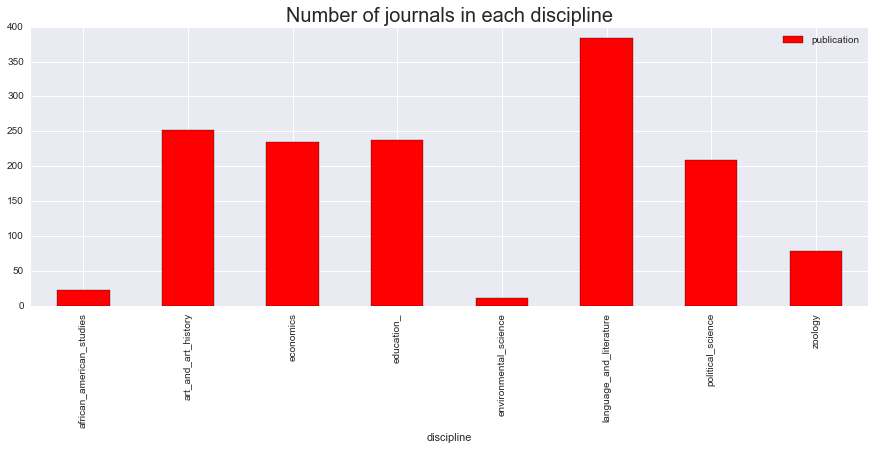

In [13]:
#plot unique journals 

data['UniqueJournal'] = data.duplicated('publication').astype(int)
f = data[['publication','discipline',]][(data['UniqueJournal']==0)].groupby('discipline').count()\
.plot(color = 'r', kind = 'bar', figsize=(15,5))
f = plt.title("Number of journals in each discipline", fontsize=20)

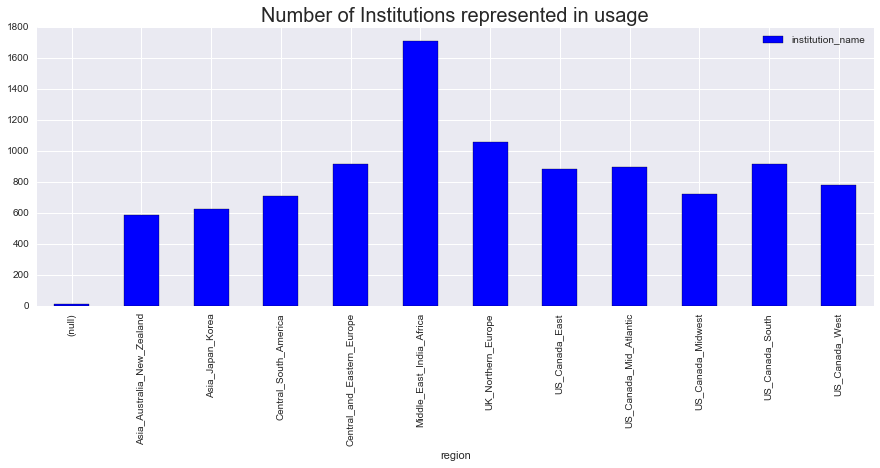

In [14]:
#plot unique institutions 

data['UniqueIns'] = data.duplicated('sitename').astype(int) # int will convert False to 0 and True to 1
f = data[['institution_name','region',]][(data['UniqueIns']==0)].groupby('region').count().\
plot(color = 'b', kind = 'bar', figsize=(15,5))
f = plt.title("Number of Institutions represented in usage", fontsize=20)

### Prepare WHED Academic Program Data Map

JSTOR Licensing Editors mapped the 660 WHED program of study terms (referred to as "field of study" or "FOS" by WHED) to the 80 JSTOR disciplines. Using this key, I can select all WHED fields of study that are mapped to the JSTOR disciplines I have selected for analysis.

In [17]:
####### only need to do this for the first dataset
disc = pd.read_excel('JSTOR_WHED_Disciplines.xlsx', header=0)
disc.head()

,FOSDisplay,JSTOR_Discipline_L2,JSTOR_Discipline_L1
0,Administrative Law,Law,Law
1,African American Studies,African American Studies,Area Studies
2,African Languages,African Studies,Area Studies
3,African Studies,African Studies,Area Studies
4,Afrikaans,African Studies,Area Studies


In [18]:
####### only need to do this for the first dataset

#chosen disciplines for train/fit/test data- create dictionary to key each discipline to appropriate dataset
disc_key = {'african_american_studies':'train', 'art_and_art_history':'train', 'economics':'train', 'education':'train',\
            'environmental_science':'train',\
           'language_and_literature':'train', 'political_science':'train', 'zoology':'train',\
           'african_studies':'fit', 'archaeology':'fit', 'biological_sciences':'fit', 'history':'fit', \
           'international_relations':'fit', 'law':'fit', 'philosophy':'fit', 'anthropology':'test',\
           'architecture_and_architectural_history':'test', 'botany_and_plant_sciences':'test', \
           'business':'test', 'classical_studies':'test', 'jewish_studies':'test', 'sociology':'test'}

#replace spaces in disciplines list and map JSTOR discipline to disc_key dictionary
disc['JSTOR_Discipline_L2'] = disc['JSTOR_Discipline_L2'].str.replace(' ', '_').str.lower()
disc['dataset'] = disc['JSTOR_Discipline_L2'].map(disc_key)

#drop null rows (aka fields of study not in disciplines I have selected)
disc = disc[pd.notnull(disc['dataset'])]

#evaluate
print "number of Fields of Study represented in each JSTOR discipline"
disc['JSTOR_Discipline_L2'].value_counts()

number of Fields of Study represented in each JSTOR discipline


education                                 45
law                                       32
art_and_art_history                       31
biological_sciences                       25
business                                  19
history                                   14
botany_and_plant_sciences                 11
environmental_science                     10
sociology                                  9
economics                                  9
architecture_and_architectural_history     7
language_and_literature                    7
classical_studies                          6
philosophy                                 6
african_studies                            6
anthropology                               4
jewish_studies                             3
international_relations                    3
political_science                          3
archaeology                                2
zoology                                    1
african_american_studies                   1
Name: JSTO

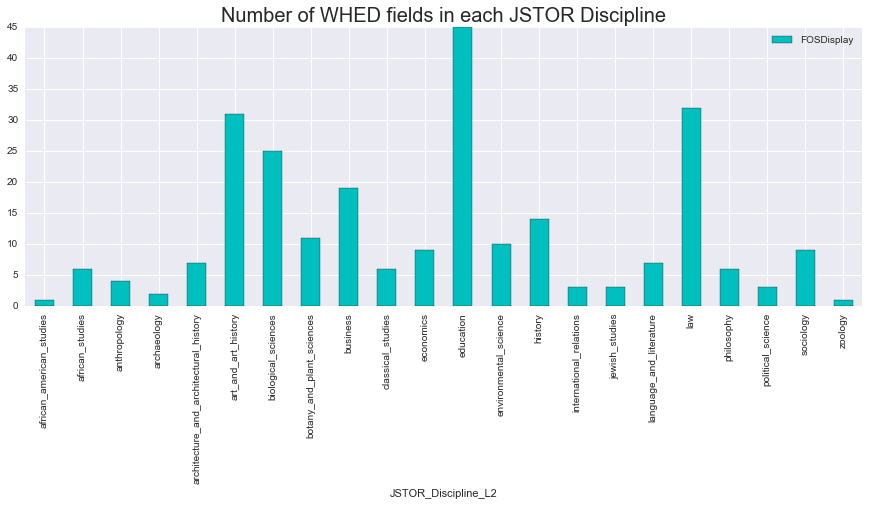

In [19]:
####### only need to do this for the first dataset

#plot # of FOS in each discipline
f = disc[['JSTOR_Discipline_L2','FOSDisplay',]].groupby('JSTOR_Discipline_L2').count().plot(color = 'c', kind = 'bar', figsize=(15,5))
f = plt.title("Number of WHED fields in each JSTOR Discipline", fontsize=20)

### Join WHED-JSTOR Discipline map to the WHED dataset

The WHED dataset contains a single row of data for every fields of study offered at an institution. So, a school with 5 fields of Study listed will be represented as 5 rows of the dataset. 

In [20]:
####### only need to do this for the first dataset


#read in WHED dataset containing information on each Program of Study for each institution
whed = pd.read_excel('WHED_Export_updated_3-23-16.xlsx')
whed.head()


#merge discipline map onto WHED data so that every row contains a column indicating which JSTOR discipline that program 
#of study belongs to (if program of study is within one of selected disciplines- else will be excluded)
whed_data = pd.merge(whed, disc, how='inner', on='FOSDisplay')

#select just WHED data columns we want to merge into JSTOR usage data
whed_data = whed_data[['CRMID', 'FOSDisplay', 'JSTOR_Discipline_L2','dataset']]

#drop duplicates
whed_data= whed_data.drop_duplicates()


#create pivot table on discipline column to get counts of Fields of Study for each school in each discipline-
# will produce a table with each school in single row with each Discipline as a columns
whed = pd.pivot_table(whed_data, aggfunc=len, columns = 'JSTOR_Discipline_L2', index='CRMID')


#create new df without tiered indices
whed_single = pd.DataFrame(whed.to_records())


#get list of discipline names to use as column names on new dataframe
list_disc = disc['JSTOR_Discipline_L2'].unique().tolist()
list_desc = sorted(list_disc)
new_columns = ['CRMID'] + list_desc


#snip off any unnecessary columns and rename with list of JSTOR disciplines
whed_single = whed_single.ix[:,:len(new_columns)]
print len(whed_single.columns)
whed_single.columns = new_columns

#show new data table
whed_single.head()

23


,CRMID,african_american_studies,african_studies,anthropology,archaeology,architecture_and_architectural_history,art_and_art_history,biological_sciences,botany_and_plant_sciences,business,...,environmental_science,history,international_relations,jewish_studies,language_and_literature,law,philosophy,political_science,sociology,zoology
0,000-187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000-191,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000-192,NaN,NaN,1,NaN,NaN,NaN,2,NaN,1,...,NaN,1,NaN,NaN,1,1,1,1,1,NaN
3,000-194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
4,000-196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,2,NaN,1,2,NaN,NaN,NaN,NaN


In [13]:
####### only need to do this for the first dataset

#write to new doc so don't need to repeat transforms
whed_single.to_csv('whed_columns.csv', index=False)

### Join suppemental datasets onto  JSTOR usage dataset

Usage volume is likely to vary across institutions, perhaps even those I consider to be categorically similar. In an attempt to account for this, I will include overall JSTOR usage statistics for each institution, to see what proportion of the total usage a single journal represents. For the same reason, I also include the usage for an institution for the collection of journals to which a certain journal belongs. 

In [21]:
#join data for total JSTOR usage and usage for collection containing that journal 
total_usage = pd.read_csv('jstor_usage_by_ins.csv')
collection_usage = pd.read_csv('jstor_usage_by_collection.csv')


#each of these files has a caccess column- this needs to be renamed for clarity as there is a caccess value for 
#journal usage, total institution usage, and total collection usage.
#for each of these datasets, keep only the two needed columns
data['journal_access'] = data['caccess']
total_usage['total_jstor_access'] = total_usage['caccess']
collection_usage['collectionID'] = collection_usage['system_id'].map(str) + ", " + collection_usage['collection'].map(str)
collection_usage['collection_access'] = collection_usage['caccess']

#remove unwanted columns
total_usage = total_usage[['system_id', 'total_jstor_access']]
c = collection_usage[['collectionID', 'collection_access']]
data = data.drop('caccess', 1)

#create column with institutionID and collectionName for mapping to collection usage
data['collectionID'] = data['system_id'].map(str) + ", " + data['collection'].map(str)

#merge (left join) to keep institutions that I didn't gather total usage for- these are non-
#higher ed communities- can drop them later but leave in, in case they provide interesting

data = pd.merge(data, c, how='left', on='collectionID')

data = pd.merge(data, total_usage, how='left', on='system_id')

# add total number of WHED fields of study and total number of JSTOR collections
add_data = pd.read_excel('FOS_INS_Counts_Total.xlsx')
total_collections = pd.read_csv('JSTOR_Number_Collections.csv')
data = pd.merge(data, add_data, how = 'left', on = 'system_id' )
data = pd.merge(data, total_collections, how = 'left', on = 'system_id')

In [23]:
#write to csv
filename = data_set + '_enriched.csv'
data.to_csv(filename)

#verify data
data.drop(['institution_name', 'sitename'], 1).head()

,collection,devnations,discipline,institution_classification,institution_community,institution_country,institution_rank,institution_state,journalid,publication,region,system_id,UniqueJournal,UniqueIns,journal_access,collectionID,collection_access,total_jstor_access,FOS_Total,umber_collections
0,Arts & Sciences I Collection,No,african_american_studies,Very_Large,Higher_Education,United_States,A,DC,10.2307/j100209,Journal of Black Studies,US_Canada_Mid_Atlantic,019-571,0,0,5619,"019-571, Arts & Sciences I Collection",45904,185045,81,13
1,Arts & Sciences I Collection,No,african_american_studies,Very_Large,Higher_Education,Canada,C,Alberta,10.2307/j100241,Journal of Negro Education,US_Canada_West,019-262,0,0,5276,"019-262, Arts & Sciences I Collection",329221,1781906,330,20
2,Arts & Sciences I Collection,No,african_american_studies,Very_Large,Higher_Education,United_States,C,FL,10.2307/j100241,Journal of Negro Education,US_Canada_South,019-360,1,0,4984,"019-360, Arts & Sciences I Collection",282999,1241239,98,9
3,Arts & Sciences I Collection,No,african_american_studies,Very_Large,Higher_Education,United_States,A,PA,10.2307/j100241,Journal of Negro Education,US_Canada_Mid_Atlantic,019-345,1,0,4468,"019-345, Arts & Sciences I Collection",288496,1543975,46,22
4,Arts & Sciences I Collection,No,african_american_studies,Medium,Higher_Education,United_States,A,NY,10.2307/j100016,Callaloo,US_Canada_East,020-445,0,0,4376,"020-445, Arts & Sciences I Collection",126388,751646,70,17


### Join WHED Fields of Study data to JSTOR usage data

In [24]:
#open jstor usage data
data = pd.read_csv(filename)

#open WHED fields of study data
whed = pd.read_csv('whed_columns.csv')

In [ ]:
#only want WHED columns for the disciplines included in the train dataset
whed_train = ['african_american_studies', 'art_and_art_history', 'economics', 'education',\
            'environmental_science', 'language_and_literature',\
           'political_science', 'zoology']

whed_fit = ['african_studies', 'archaeology', 'biological_sciences', 'history', \
           'international_relations', 'law', 'philosophy']

whed_test = ['anthropology','architecture_and_architectural_history', 'botany_and_plant_sciences', \
           'business', 'classical_studies', 'jewish_studies', 'sociology']





"""""""""""""""""""""""""""""""""""""""select your discipline set"""""""""""""""""""""""""""""""""""""""""


whed_select = whed_test


"""""""""""""""""""""""""""""""""""""""""""don't forget"""""""""""""""""""""""""""""""""



In [1]:

#loop through list of disciplines to append data from WHED Fields of Study to JSTOR disciplines usage data. 

#doing as loop to only register number of fields for the relevant discipline- meaning, an institution
#with a journal in education and a journal zoology will have two rows of data-- one with the zoology journal, zoology usage, 
#and zoology program information, and one with the education journal, education usage, and education program information.

disc_data = []
i = 0
#while i < 8:
while i <len(whed_select) :
    discipline = whed_select[i]
    whed_specific = whed[['CRMID', discipline]]
    whed_specific['numberRelevantFOS'] = whed_specific[discipline]
    whed_specific = whed_specific.drop(discipline, 1)
    append_data = data[data['discipline'] == discipline]
    append_data['CRMID'] = append_data['system_id']
    append_data.drop('system_id', 1)
    all_data = pd.merge(append_data, whed_specific, how='left', on='CRMID')
    disc_data.append(all_data)
    i += 1

In [28]:
#concatenate all discipline dataframes and write to new file
full_data = pd.concat(disc_data)
filename = data_set + '_normalized.csv'
full_data.to_csv(filename, index=False)

In [401]:
#check on data
full_data[full_data['discipline']=='art_and_art_history'].drop(['institution_name', 'sitename'], 1).head()

,collection,devnations,discipline,institution_classification,institution_community,institution_country,institution_rank,institution_state,journalid,publication,...,total_jstor_access,FOS_Total,umber_collections,CRMID,numberRelevantFOS,has_whed_in_discipline,av_jounal_use,journal_in_collection,journal_in_total,FOS_prop
74961,Arts & Sciences II Collection,No,art_and_art_history,Very_Large,Higher_Education,United_States,A,NY,10.2307/j100058,American Journal of Archaeology,...,14.775302,359,23,019-621,10,True,27169,0.802923,0.691007,0.027855
74962,Arts & Sciences I Collection,No,art_and_art_history,Large,Higher_Education,United_Kingdom,A,(null),10.2307/j100377,Speculum,...,14.719124,81,16,020-148,5,True,20405,0.746002,0.674193,0.061728
74963,Arts & Sciences I Collection,No,art_and_art_history,Large,Higher_Education,Australia,A,Victoria,10.2307/j100377,Speculum,...,14.856137,94,20,018-731,3,True,17158,0.738215,0.656309,0.031915
74964,Arts & Sciences III Collection,No,art_and_art_history,Large,Higher_Education,United_Kingdom,C,(null),10.2307/j100112,Burlington Magazine,...,13.526928,52,10,018-084,1,True,16734,0.804317,0.718951,0.019231
74965,Arts & Sciences I Collection,No,art_and_art_history,Large,Higher_Education,United_Kingdom,A,(null),10.2307/j100377,Speculum,...,14.632088,85,22,020-104,1,True,14780,0.732960,0.656163,0.011765


#### About the Data
A single row of this dataset represents usage for a single journal at a single institution. In each row there is information about the institution and its programs of study.
<br>
<br>
<b>journal_access:</b> usage of the specific journal at the institution
<br>
<br>
<b>collection_access:</b> usage for the collection containing that journal at the institution
<br>
<br>
<b>total_jstor_access:</b> usage for all JSTOR content at the institution
<br>
<br>
<b>number_collections:</b> number of JSTOR collections the institution subscribes to
<br>
<br>
<b>numberRelevantFOS:</b> number of WHED Fields of Study at the institution within the discipline of the journal
<br>
<br>
<b>FOS_Total:</b> number of WHED Fields of Study at the institution across any discipline


## Training and fitting data

In [8]:
#open jstor usage data for train, fit, or test data

data = pd.read_csv(filename)


In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2431598 entries, 0 to 2431597
Data columns (total 25 columns):
Unnamed: 0                    int64
collection                    object
devnations                    object
discipline                    object
institution_classification    object
institution_community         object
institution_country           object
institution_name              object
institution_rank              object
institution_state             object
journalid                     object
publication                   object
region                        object
sitename                      object
system_id                     object
UniqueJournal                 int64
UniqueIns                     int64
journal_access                int64
collectionID                  object
collection_access             float64
total_jstor_access            float64
FOS_Total                     float64
umber_collections             int64
CRMID                         object
n

In [253]:
#fill in any null values for number of fields of study with 0 and tranfsform numeric data

#drop null rows- don't want to just fill with average because don't know what that could do to predictive model. 
full_data = data[data['journalid'].notnull()]
full_data = full_data[full_data['total_jstor_access'].notnull()]
full_data = full_data[full_data['collection_access'].notnull()]
full_data=full_data.drop('Unnamed: 0', 1)

#use log transformations instead of scalar so that can reverse engineer actual usage predictions at the end- 
#plus confirmed in trials there was not a substantial difference in model performance 
#using log transformation versus scalar transformation
full_data['total_jstor_access'] = np.log(full_data['total_jstor_access'])
full_data['collection_access'] = np.log(full_data['collection_access'])
full_data['journal_access'] = np.log(full_data['journal_access'])
full_data['journal_in_collection'] = full_data['journal_access'] / full_data['collection_access']
full_data['journal_in_total'] = full_data['journal_access'] / full_data['total_jstor_access']
full_data['FOS_prop'] = full_data['numberRelevantFOS']/full_data['FOS_Total']

In [337]:
full_data.columns

Index([u'collection', u'devnations', u'discipline',
       u'institution_classification', u'institution_community',
       u'institution_country', u'institution_name', u'institution_rank',
       u'institution_state', u'journalid', u'publication', u'region',
       u'sitename', u'system_id', u'UniqueJournal', u'UniqueIns',
       u'journal_access', u'collectionID', u'collection_access',
       u'total_jstor_access', u'FOS_Total', u'umber_collections', u'CRMID',
       u'numberRelevantFOS', u'has_whed_in_discipline', u'av_jounal_use',
       u'journal_in_collection', u'journal_in_total', u'FOS_prop'],
      dtype='object')

## Results. 

I divided my evaluation into two categories: 1) predicting usage for journals within a particular JSTOR discipline, and 2) predicting, based on usage of journals within a particular discipline, whether that institution has WHED Fields of Study in that discipline. 

For 1), I tested a variety of linear regression models, including LinearRegression, Ridge, and Lasso models with a variety of Alpha scores (from .0001 to 10000). There was no appreciable increase n score using either Ridge or Lasso as opposed to LinearRegression, so I will present the results of the linear regression.

For 2), I first tried to use linear regression to predict how many WHED Fields of Study in that discipline an institution would have. These scores were unsatisfactory (r2 value of .15 at best). Given the range of possible values (from 0 to 22 WHED Fields of study) and the known variation in quality of WHED data reported, this was not particularly surprising. The predictive success was nearly twice as high when just trying to predict whether an institution had, or did not have, any WHED Fields of Study in a discipline. However, .25 is still not an exciting r2 score.

Given the increased success in a binary predictive model for WHED fields of study, I then modeled the data using Logistic Regression, which much better results: recall of .57 for all data, and .78 recall when the lowest usage datapoints were removed.


#### Predicting usage for journals within a particular JSTOR discipline

In [254]:
#group data by average journal usage in a particular discipline- compared to non-aggregated data in testing, 
#the r2 value is nearly .2 higher for the aggregated data


agg_data = full_data.groupby(['sitename', 'discipline', 'institution_classification', 'institution_country',\
                             'institution_rank', 'institution_state', 'devnations']).mean()
agg_data = agg_data.reset_index()

agg_data.describe()

,UniqueJournal,UniqueIns,journal_access,collection_access,total_jstor_access,FOS_Total,umber_collections,numberRelevantFOS,journal_in_collection,journal_in_total,FOS_prop
count,26994.000000,26994.000000,26994.000000,26994.000000,26994.000000,21104.000000,26994.000000,20806.000000,26924.000000,26991.000000,20806.000000
mean,0.999637,0.955674,1.934795,7.383660,9.473979,51.028478,9.867711,0.905075,0.236550,0.189850,0.022076
std,0.007088,0.157163,1.274426,2.132115,2.217857,47.951096,6.127985,1.658628,0.121475,0.106964,0.053555
min,0.333333,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.876145,6.089046,8.090709,23.000000,5.000000,0.000000,0.148280,0.106607,0.000000
50%,1.000000,1.000000,1.809715,7.670735,9.583213,39.000000,8.000000,0.000000,0.241204,0.190276,0.000000
75%,1.000000,1.000000,2.861069,8.921902,11.042970,63.000000,16.000000,1.000000,0.327928,0.268088,0.025641
max,1.000000,1.000000,7.410370,13.036780,14.856137,661.000000,23.000000,22.000000,1.000000,0.735569,1.000000


### What does this look like graphically?

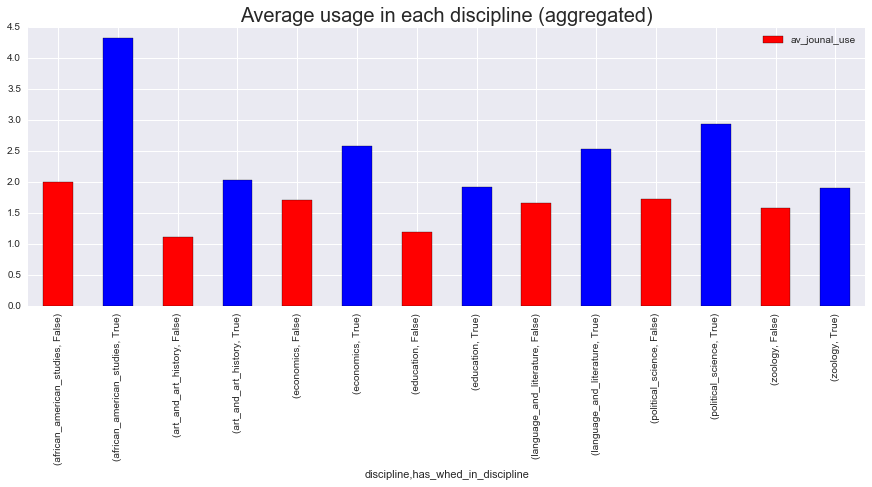

In [408]:
#usage across disciplines is relatively the same- which could be part of the reason that predicting power 
#is not much better when discipline-specific information is added; usage seems discipline agnostic.
graph_agg = agg_data.fillna(0)
graph_agg['has_whed_in_discipline'] = graph_agg['numberRelevantFOS']!= 0
graph_agg['av_jounal_use'] = graph_agg['journal_access']
f = graph_agg[['av_jounal_use','discipline', 'has_whed_in_discipline']].groupby(['discipline', 'has_whed_in_discipline']).mean()\
.plot(color = ['r', 'b'], kind = 'bar', figsize=(15,5))
f = plt.title("Average usage in each discipline (aggregated)", fontsize=20)

There is a clear trend in general that institutions with WHED Fields of Study in a particular discipline have, on average, higher usage (and some have substantially higher usage).
<br>
<br>
<br>
What does this difference look like overall?

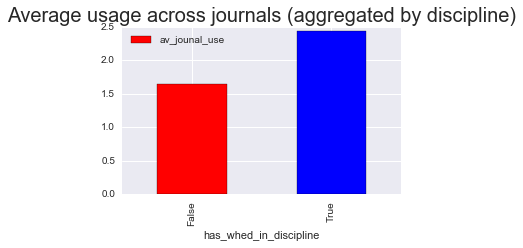

In [410]:
graph_agg = agg_data.fillna(0)
graph_agg['has_whed_in_discipline'] = graph_agg['numberRelevantFOS']!= 0
graph_agg['av_jounal_use'] = graph_agg['journal_access']
f = graph_agg[['av_jounal_use','has_whed_in_discipline']].groupby(['has_whed_in_discipline']).mean()\
.plot(color = ['r', 'b'], kind = 'bar', figsize=(5,3))
f = plt.title("Average usage across journals (aggregated by discipline)", fontsize=20)

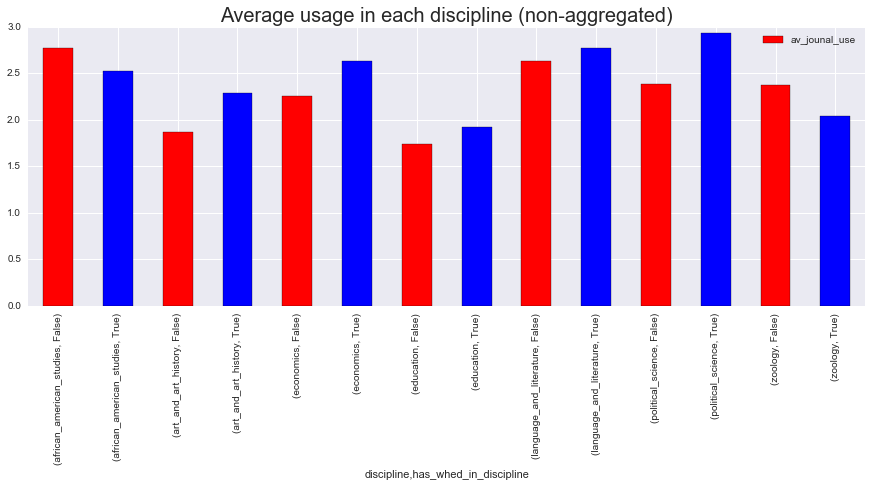

In [411]:
journal_av = full_data
journal_av['av_jounal_use'] = journal_av['journal_access']
journal_av['has_whed_in_discipline'] = journal_av['numberRelevantFOS']!= 0
f = journal_av[['av_jounal_use','discipline', 'has_whed_in_discipline']].groupby(['discipline', 'has_whed_in_discipline']).mean()\
.plot(color = ['r', 'b'], kind = 'bar', figsize=(15,5))
f = plt.title("Average usage in each discipline (non-aggregated)", fontsize=20)

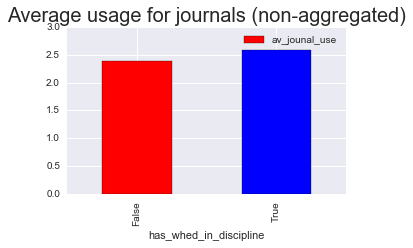

In [413]:
journal_av = full_data
journal_av['av_jounal_use'] = journal_av['journal_access']
f = journal_av[['av_jounal_use','discipline','has_whed_in_discipline']].groupby('has_whed_in_discipline').mean()\
.plot(color = ['r', 'b'], kind = 'bar', figsize=(5,3))
f = plt.title("Average usage for journals (non-aggregated)", fontsize=20)

Given these graphs, it does look like whether or not an institution has fields of study in a discipline impacts usage, and the trend is more noticeable when usage is aggregated according to usage within a discipline at an institution (instead of by individual journals).

### Modeling

In [148]:
#predict an institution's average usage for journals in a specific discipline
#without knowing anything about general JSTOR usage

test_data = agg_data.fillna(0)
test_data = test_data.drop('journal_in_collection', 1)
test_data = test_data.drop('UniqueJournal', 1)
test_data = test_data.drop('UniqueIns', 1)
test_data = test_data.drop('journal_in_total', 1)
test_data = test_data.drop('collection_access', 1)
test_data = test_data.drop('total_jstor_access', 1)
# test_data = test_data.drop('av_jounal_use', 1)

dv = DictVectorizer(sparse=True)
testing_data = test_data.drop('journal_access', 1)
X = dv.fit_transform(testing_data.T.to_dict().values())
y=test_data['journal_access']
print "without any JSTOR usage info:"
print "features: ", testing_data.columns
print "Mean Absolute Error:", -cross_val_score(LinearRegression(), X, y, cv=3, scoring='mean_absolute_error').mean()
print "r2 value:", cross_val_score(LinearRegression(), X, y, cv=3, scoring='r2').mean()
print " "

#predict an institution's average usage for journals in a specific discipline
#only knowing total JSTOR usage- basically, get in ballpark of how much the institution uses JSTOR

test_data = agg_data.fillna(0)
test_data = test_data.drop('journal_in_collection', 1)
test_data = test_data.drop('UniqueJournal', 1)
test_data = test_data.drop('UniqueIns', 1)
test_data = test_data.drop('journal_in_total', 1)
test_data = test_data.drop('collection_access', 1)

dv = DictVectorizer(sparse=True)
testing_data = test_data.drop('journal_access', 1)
X = dv.fit_transform(testing_data.T.to_dict().values())
y=test_data['journal_access']
print "with total JSTOR usage known:"
print "features: ", testing_data.columns
print "Mean Absolute Error:", -cross_val_score(LinearRegression(), X, y, cv=3, scoring='mean_absolute_error').mean()
print "r2 value:", cross_val_score(LinearRegression(), X, y, cv=3, scoring='r2').mean()
print " "

#predict average usage in a discipline 
#knowing total JSTOR usage and usage for a particular collection
test_data = agg_data.fillna(0)
test_data = test_data.drop('journal_in_collection', 1)
test_data = test_data.drop('UniqueJournal', 1)
test_data = test_data.drop('UniqueIns', 1)
test_data = test_data.drop('journal_in_total', 1)

dv = DictVectorizer(sparse=True)
testing_data = test_data.drop('journal_access', 1)
X = dv.fit_transform(testing_data.T.to_dict().values())
y=test_data['journal_access']

print "with total JSTOR usage and JSTOR Collection usage known:"
print "features: ", testing_data.columns
print "Mean Absolute Error:", -cross_val_score(LinearRegression(), X, y, cv=3, scoring='mean_absolute_error').mean()
print "r2 value:", cross_val_score(LinearRegression(), X, y, cv=3, scoring='r2').mean()


without any JSTOR usage info:
features:  Index([                  u'sitename',                 u'discipline',
       u'institution_classification',        u'institution_country',
                 u'institution_rank',          u'institution_state',
                       u'devnations',                  u'FOS_Total',
                u'umber_collections',          u'numberRelevantFOS',
                         u'FOS_prop'],
      dtype='object')
Mean Absolute Error: 0.660105781446
r2 value: 0.551979402612
 
with total JSTOR usage known:
features:  Index([                  u'sitename',                 u'discipline',
       u'institution_classification',        u'institution_country',
                 u'institution_rank',          u'institution_state',
                       u'devnations',         u'total_jstor_access',
                        u'FOS_Total',          u'umber_collections',
                u'numberRelevantFOS',                   u'FOS_prop'],
      dtype='object')
Mean Absolut

#### The above analysis includes information on WHED Fields of Study. What happens to the score when the WHED data is removed?

In [397]:
#predict average usage in a discipline 
#knowing total JSTOR usage and usage for a particular collection, and without FOS information

test_data = agg_data.fillna(0)
test_data = test_data.drop('journal_in_collection', 1)
test_data = test_data.drop('UniqueJournal', 1)
test_data = test_data.drop('UniqueIns', 1)
test_data = test_data.drop('journal_in_total', 1)
test_data = test_data.drop('numberRelevantFOS', 1)
test_data = test_data.drop('FOS_Total', 1)
test_data = test_data.drop('FOS_prop', 1)
test_data = test_data.drop('av_jounal_use', 1)


dv = DictVectorizer(sparse=True)
testing_data = test_data.drop('journal_access', 1)
X = dv.fit_transform(testing_data.T.to_dict().values())
y=test_data['journal_access']
print "Same analysis as above, but without WHED information"
print "features: ", testing_data.columns
print "Mean Absolute Error:", -cross_val_score(LinearRegression(), X, y, cv=3, scoring='mean_absolute_error').mean()
print "r2 value:", cross_val_score(LinearRegression(), X, y, cv=3, scoring='r2').mean()

Same analysis as above, but without WHED information
features:  Index([u'sitename', u'discipline', u'institution_classification',
       u'institution_country', u'institution_rank', u'institution_state',
       u'devnations', u'collection_access', u'total_jstor_access',
       u'umber_collections', u'has_whed_in_discipline'],
      dtype='object')
Mean Absolute Error: 0.471724636239
r2 value: 0.763775685695


### Preliminary Results


There is very little difference in predictive power with or without WHED data for a given institution. 

The most powerful usage predictor is JSTOR usage overall. Usage within a particular collection provides a bit of a boost, as does location of institution (country and state) and size of institution (classification).

Surprisingly, institution size is not a good predictor for content use within a discipline- indicating that institution size is not a powerful indicator of JSTOR usage.

### Predicting if an institution has programs of study in a particular discipline, based on their usage

In exploration, Logistic Regression proved a far better model than logistic regression (i.e., it was not possible to find a good model to predict how many WHED Fields of Study an institution may have, but it is possible to predict if they have or do not have WHED Fields of Study in a discipline).

In [255]:
#predict whether an institution has or does not have WHED FOS in a discipline
test_data = agg_data.fillna(0)
test_data['has_whed'] = test_data['numberRelevantFOS'] != 0
test_data = test_data.drop('journal_in_collection', 1)
test_data = test_data.drop('UniqueJournal', 1)
test_data = test_data.drop('UniqueIns', 1)
test_data = test_data.drop('journal_in_total', 1)
test_data = test_data.drop('FOS_Total', 1)
test_data = test_data.drop('FOS_prop', 1)
test_data = test_data.drop('numberRelevantFOS', 1)

dv = DictVectorizer(sparse=True)
testing_data = test_data.drop('has_whed', 1)
X = dv.fit_transform(testing_data.T.to_dict().values())
y=test_data['has_whed']
print "predict whether institution has or does not have WHED FOS in discipline"
print "features: ", testing_data.columns
print "Recall:", cross_val_score(LogisticRegression(), X, y, cv=3, scoring='recall').mean()
print "Precision:", cross_val_score(LogisticRegression(), X, y, cv=3, scoring='precision').mean()
print " "


#drop instances where journals usage is low
test_data = agg_data.fillna(0)
test_data['has_whed'] = test_data['numberRelevantFOS'] != 0
test_data = test_data.drop('journal_in_collection', 1)
test_data = test_data.drop('UniqueJournal', 1)
test_data = test_data.drop('UniqueIns', 1)
test_data = test_data.drop('journal_in_total', 1)
test_data = test_data.drop('FOS_Total', 1)
test_data = test_data.drop('FOS_prop', 1)
test_data = test_data.drop('numberRelevantFOS', 1)
test_data = test_data.drop(test_data[test_data.journal_access < 2].index)

dv = DictVectorizer(sparse=True)
testing_data = test_data.drop('has_whed', 1)
X = dv.fit_transform(testing_data.T.to_dict().values())
y=test_data['has_whed']
print "predict whether institution has or does not have WHED FOS in discipline, with low usage removed"
print "features: ", testing_data.columns
print "Recall:", cross_val_score(LogisticRegression(class_weight={False: .4, True:.5}), X, y, cv=3, scoring='recall').mean()
print "Precision:", cross_val_score(LogisticRegression(class_weight={False: .4, True:.5}), X, y, cv=3, scoring='precision').mean()
print " "

predict whether institution has or does not have WHED FOS in discipline
features:  Index([u'sitename', u'discipline', u'institution_classification',
       u'institution_country', u'institution_rank', u'institution_state',
       u'devnations', u'journal_access', u'collection_access',
       u'total_jstor_access', u'umber_collections'],
      dtype='object')
Recall: 0.575067192078
Precision: 0.660212125035
 
predict whether institution has or does not have WHED FOS in discipline, with low usage removed
features:  Index([u'sitename', u'discipline', u'institution_classification',
       u'institution_country', u'institution_rank', u'institution_state',
       u'devnations', u'journal_access', u'collection_access',
       u'total_jstor_access', u'umber_collections'],
      dtype='object')
Recall: 0.844258112329
Precision: 0.69729265942
 


### Preliminary Results


Removing instances of very low usage increase the precision (a bit) and recall (a lot) of the model. In further refining this model, I would work to increase recall without any loss in precision (.69 is about as low as could be considered acceptable for this use case). 

<br>
<br>
<br>
## Fitting and Testing Data
<br>
### Predicting Usage: Linear Regression

In [256]:
#combine fit and test data- add column indicating dataset to be able to ID where to divide them later
fitted_data = pd.read_csv('fit_normalized.csv')
fitted_data['dataset'] = 'fit'
test_data = pd.read_csv('test_normalized.csv')
test_data['dataset'] = 'test'
df = [fitted_data, test_data]
fit_data = pd.concat(df)
fit_data = fit_data[fit_data['journalid'].notnull()]
fit_data = fit_data[fit_data['total_jstor_access'].notnull()]
fit_data = fit_data[fit_data['collection_access'].notnull()]
fit_data = fit_data.drop('Unnamed: 0', 1)
fit_data['total_jstor_access'] = np.log(fit_data['total_jstor_access'])
fit_data['collection_access'] = np.log(fit_data['collection_access'])
fit_data['journal_access'] = np.log(fit_data['journal_access'])
fit_data['journal_in_collection'] = fit_data['journal_access'] / fit_data['collection_access']
fit_data['journal_in_total'] = fit_data['journal_access'] / fit_data['total_jstor_access']
fit_data['FOS_prop'] = fit_data['numberRelevantFOS']/fit_data['FOS_Total']
fit_data['number_collections'] = fit_data['umber_collections']
fit_data = fit_data.drop('umber_collections', 1)

fit_agg_data = fit_data.groupby(['sitename', 'discipline', 'institution_classification', 'institution_country',\
                             'institution_rank', 'institution_state', 'devnations', 'dataset']).mean()
fit_agg_data = fit_agg_data.reset_index()
fit_agg_data.describe()

,UniqueJournal,UniqueIns,journal_access,collection_access,total_jstor_access,FOS_Total,numberRelevantFOS,journal_in_collection,journal_in_total,FOS_prop,number_collections
count,57104.000000,57104.000000,57104.000000,57104.000000,57104.000000,45221.000000,44674.000000,56930.000000,57092.000000,44674.000000,57104.000000
mean,0.999608,0.964044,2.038902,7.478153,9.674503,52.529179,0.752227,0.248516,0.197997,0.015951,10.104966
std,0.005560,0.150030,1.354403,2.098350,2.161292,48.926950,1.289619,0.137497,0.118681,0.035466,6.025178
min,0.580000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.902561,6.233738,8.326517,24.000000,0.000000,0.149541,0.107312,0.000000,5.000000
50%,1.000000,1.000000,1.920776,7.791799,9.801898,40.000000,0.000000,0.247671,0.194586,0.000000,9.000000
75%,1.000000,1.000000,3.037045,8.991332,11.200500,65.000000,1.000000,0.338390,0.276002,0.023256,16.000000
max,1.000000,1.000000,8.531096,12.721223,14.856137,661.000000,18.000000,1.000000,1.000000,1.000000,23.000000


In [257]:
#sort-by dataset so can split according to length of fit and test
fit_agg_data = fit_agg_data.sort_values('dataset')
fit_agg_data.drop('sitename', 1).head()

,discipline,institution_classification,institution_country,institution_rank,institution_state,devnations,dataset,UniqueJournal,UniqueIns,journal_access,collection_access,total_jstor_access,FOS_Total,numberRelevantFOS,journal_in_collection,journal_in_total,FOS_prop,number_collections
0,african_studies,(null),United_States,(null),NY,(null),fit,1,0.981481,2.669456,9.258784,11.853034,NaN,NaN,0.284755,0.225213,NaN,13
23951,law,Very_Small,Turkey,D,(null),No,fit,1,1.000000,1.398226,6.461127,9.113168,40,2,0.215314,0.153429,0.050000,12
23949,international_relations,Very_Small,Turkey,D,(null),No,fit,1,1.000000,1.937451,7.023774,9.113168,40,1,0.272818,0.212599,0.025000,12
23948,history,Very_Small,Turkey,D,(null),No,fit,1,1.000000,1.398928,6.589176,9.113168,40,1,0.204981,0.153506,0.025000,12
45543,law,Very_Small,United_States,D,HI,No,fit,1,1.000000,1.721670,7.580989,9.576649,14,1,0.226709,0.179778,0.071429,7


In [5]:
fit_data = fit_agg_data.fillna(0)
fit_data = fit_data.drop('journal_in_collection', 1)
fit_data = fit_data.drop('UniqueJournal', 1)
fit_data = fit_data.drop('UniqueIns', 1)
fit_data = fit_data.drop('journal_in_total', 1)

#drop value to predict- will later split into testing and training
fitting_data = fit_data.drop('journal_access', 1)


dv = DictVectorizer(sparse=True)

X = dv.fit_transform(fitting_data.T.to_dict().values())

X_fit = X[:len(fit_agg_data[fit_agg_data['dataset']=='fit'])]
X_test = X[len(fit_agg_data[fit_agg_data['dataset']=='fit']):]

y_fit = fit_data['journal_access'][:len(fit_agg_data[fit_agg_data['dataset']=='fit'])]
actual_values = fit_data['journal_access'][len(fit_agg_data[fit_agg_data['dataset']=='fit']):]

#confirm X and y for two datasets are the same
print "full data:"
print X.shape
print " "

print "fit data:"
print "Features:", X_fit.shape
print "y:", len(y_fit)
print " "

print "test data:"
print "Features:", X_test.shape
print "values to predict:", len(actual_values)

full data:
(57104, 5636)
 
fit data:
Features: (29417, 5636)
y: 29417
 
test data:
Features: (27687, 5636)
values to predict: 27687


In [209]:
model = LinearRegression()
model.fit(X_fit, y_fit)
predict_values = model.predict(X_test)

In [211]:
new_df = pd.DataFrame(actual_values)
new_df['predict_values'] = predict_values
new_df.columns = ['actual_values', 'predict_values']
new_df['error'] = new_df['predict_values'] - new_df['actual_values']
new_df = new_df.reset_index().drop('index', 1)

In [212]:
#write predictions and actual values to document
new_df.to_csv('predictions.csv', index=False)

In [5]:
new_df.head()

,actual_values,predict_values,error
0,1.021827,1.073885,0.052058
1,1.292474,1.276701,-0.015773
2,2.079442,0.825528,-1.253913
3,1.209400,1.223869,0.014469
4,3.521143,2.986803,-0.534340


### Graph Results

Mean Absolute Error: 0.500879394209


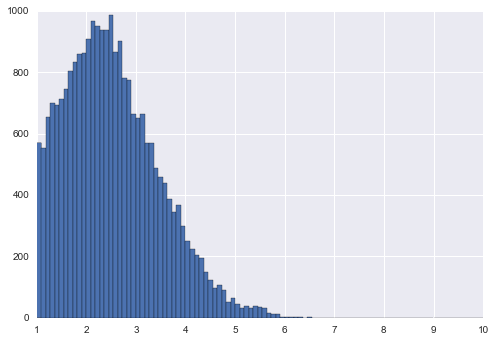

In [32]:
predicted = new_df['predict_values']
actual = new_df['actual_values']

bins = np.linspace(1, 10, 100)
f = plt.hist(predicted, bins=bins)
#f = plt.hist(actual, bins=bins, color='r')
print "Mean Absolute Error:", np.abs(new_df['error']).mean()


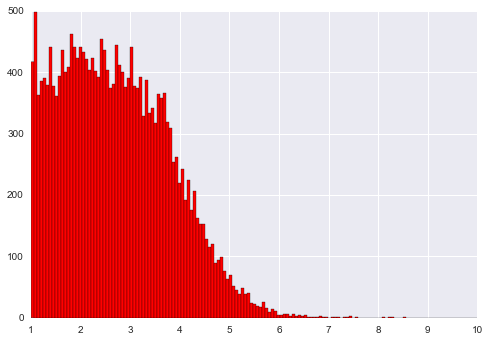

In [23]:
f = plt.hist(actual, bins=bins, color='r')

### Conclusions:
In this model, predicted usage is clustered around mean usage when compared to actual usage. This seems to imply the model does not have enough features to better represent the actual data, but rather is relying heavily on mean values. 

In the future, exploring what other features could be added to this dataset to increase the variance explained by the model would be worthwhile. Looking at specific WHED Fields of Study, instead of aggregated number within a discipline, would be a good place to begin this exploration.

## Predicting Fields of Study: Logistic Regression

In [16]:
fit_agg_data = fit_agg_data.sort_values('dataset')
fit_agg_data.drop('sitename', 1).head()

,discipline,institution_classification,institution_country,institution_rank,institution_state,devnations,dataset,UniqueJournal,UniqueIns,journal_access,collection_access,total_jstor_access,FOS_Total,numberRelevantFOS,journal_in_collection,journal_in_total,FOS_prop,number_collections
0,african_studies,(null),United_States,(null),NY,(null),fit,1,0.981481,2.669456,9.258784,11.853034,NaN,NaN,0.284755,0.225213,NaN,13
23951,law,Very_Small,Turkey,D,(null),No,fit,1,1.000000,1.398226,6.461127,9.113168,40,2,0.215314,0.153429,0.050000,12
23949,international_relations,Very_Small,Turkey,D,(null),No,fit,1,1.000000,1.937451,7.023774,9.113168,40,1,0.272818,0.212599,0.025000,12
23948,history,Very_Small,Turkey,D,(null),No,fit,1,1.000000,1.398928,6.589176,9.113168,40,1,0.204981,0.153506,0.025000,12
45543,law,Very_Small,United_States,D,HI,No,fit,1,1.000000,1.721670,7.580989,9.576649,14,1,0.226709,0.179778,0.071429,7


In [265]:
fit_data = fit_agg_data.fillna(0)
fit_data['has_whed'] = fit_data['numberRelevantFOS'] != 0
fit_data = fit_data.drop('journal_in_collection', 1)
fit_data = fit_data.drop('UniqueJournal', 1)
fit_data = fit_data.drop('UniqueIns', 1)
fit_data = fit_data.drop('journal_in_total', 1)
fit_data = fit_data.drop('FOS_Total', 1)
fit_data = fit_data.drop('FOS_prop', 1)
fit_data = fit_data.drop('numberRelevantFOS', 1)
fit_data = fit_data.drop(fit_data[fit_data.journal_access < 3].index)
print len(fit_data)

dv = DictVectorizer(sparse=True)
fitting_data = fit_data.drop('has_whed', 1)
X = dv.fit_transform(fitting_data.T.to_dict().values())

print X.shape

X_fit = X[:len(fit_data[fit_data['dataset']=='fit'])]
X_test = X[len(fit_data[fit_data['dataset']=='fit']):]
y_fit = fit_data['has_whed'][:len(fit_data[fit_data['dataset']=='fit'])]
y_actual = fit_data['has_whed'][len(fit_data[fit_data['dataset']=='fit']):]

#confirm X and y for two datasets are the same
print "full data:"
print X.shape
print " "

print "fit data:"
print "Features:", X_fit.shape
print "y:", len(y_fit)
print " "

print "test data:"
print "Features:", X_test.shape
print "values to predict:", len(y_actual)

14712
(14712, 3970)
full data:
(14712, 3970)
 
fit data:
Features: (8666, 3970)
y: 8666
 
test data:
Features: (6046, 3970)
values to predict: 6046


In [250]:
model = LogisticRegression(class_weight={False: .4, True:.5})

model.fit(X_fit, y_fit)
predict_whed = model.predict(X_test)

new_df = pd.DataFrame(y_actual)
new_df['predict_values'] = predict_whed
new_df.columns = ['actual_values', 'predict_values']
new_df['error'] = new_df['predict_values'] - new_df['actual_values']
new_df = new_df.reset_index().drop('index', 1)

new_df['status'] = new_df['actual_values'].map(str) +", "+new_df['predict_values'].map(str)
status = []
new_df['status'] = new_df['actual_values'].map(str) +", "+new_df['predict_values'].map(str)
status = []
for row in new_df['status']:
    if row == 'False, True':
        status.append('False Positive')
    elif row == 'True, False':
        status.append('False Negatve')
    elif row == 'True, True':
        status.append('True Positive')
    else:
        status.append('True Negative')
new_df['status'] = status
new_df['status'].value_counts()

print "Outcomes:" 
print new_df['error'].value_counts()
print "Observed Success:", len(new_df['error'][new_df['error']==False])/(len(new_df['error'])*1.0)

Outcomes:
False    3450
True     2596
Name: error, dtype: int64
Observed Success: 0.570625206748


This doesn't look particularly good- it is only right a bit over half of the time. However, I am most interested in correctly identifying all instititutions that have a Field of Study in a given discipline. So, although changes to the model can increase the observed success to 78%, the number of "missed" positives (aka false negatives) increases drastically. 

In [251]:
new_df['status'] = new_df['actual_values'].map(str) +", "+new_df['predict_values'].map(str)
status = []
for row in new_df['status']:
    if row == 'False, True':
        status.append('False Positive')
    elif row == 'True, False':
        status.append('False Negative')
    elif row == 'True, True':
        status.append('True Positive')
    elif row == 'False, False':
        status.append('True Negative')
new_df['status'] = status
print new_df['status'].value_counts()

True Positive     3267
False Positive    2313
False Negative     283
True Negative      183
Name: status, dtype: int64


In [252]:
TP = len(new_df['status'][new_df['status']=='True Positive'])*1.0
FP =len(new_df['status'][new_df['status']=='False Positive'])*1.0
FN = len(new_df['status'][new_df['status']=='False Negative'])*1.0

print "recall (portion of institutions with WHED Field of Study identified as having one):", round (TP/(TP + FN), 3)
print "precision (portion of times we predicted an institution had a WHED Field of Study that they actually did):", round(TP/(TP + FP), 3)


recall (portion of institutions with WHED Field of Study identified as having one): 0.92
precision (portion of times we predicted an institution had a WHED Field of Study that they actually did): 0.585


These results are not satisfactory- there are more "false negatives" than "true negatives", so the model is clearly too skewed to select positive values. In its current form, when altering the model by adjusting the weights for classifying as False or True, the only change is a substantial decrease in recall (and the precision remains around .58).

Clearly, more digging into this matter is needed.

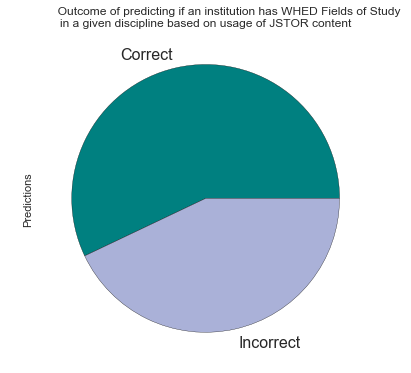

In [232]:
outcome = []
for row in new_df['error']:
    if row == False:
        outcome.append('Correct')
    else:
        outcome.append('Incorrect')
new_df['Predictions'] = outcome
f = new_df['Predictions'].value_counts().plot.pie(figsize=(6, 6), colors=['#008080', '#aab1d8'],\
fontsize = 16,title='               Outcome of predicting if an institution has WHED Fields of Study \
\nin a given discipline based on usage of JSTOR content')

### Conclusions

This model will require substantial exploration and further refinement to be useful in predicting whether an institution has WHED Fields of Study in a given discipline.

# Planning for future implementation
Moving forward, it will be possible to access all datasets used in this analysis in the same data warehouse, thus making reproduction relatively straightforward. Usage data is updated in near real-time, but given that the model focuses on usage over a 3-year period, I believe updating the data quarterly would suffice. The external WHED data will be updated in the annual data release. 

This analysis could provide a broad audience of internal users assistance in understanding usage trends, predicting interest within specific content areas, and working to build audience profiles for future projects. In order for this data to be accessible to a broad audience, it could be represented in a dashboard that allowed users to search for a particular institution, or enter specific criteria (classification X, country Y, etc.) and project results.


However, more work is needed before unleashing this analysis on a “broad” audience. This exploration will include:
<br><i> -Are certain disciplines more amenable to prediction than others?
<br>-Can this analysis be used to examine particular strengths and weaknesses in content awareness? (perhaps low usage for some institutions with relevant WHED Fields of Study points to lack of awareness regarding access to that content)
<br>-What if the 22 disciplines I selected skew in a way not generally represented across the other 60 disciplines? Would like to perform a check with another portion of discipline data.
<br>-Is examining all usage at a given institution and comparing that to their WHED Field of Study profile more successful than approaching the matter by examining all usage across journals of a specific discipline?</i>
<br>
<br>
With the exploration of these remaining questions, the value of this data will no doubt increase and allow a more successful view into the interactions of usage and academic programs at universities worldwide.